# Image classification for brain tumours

This method shows how Team 47 including Tendai Gwanzura, Angel Zelazny, Antonio Hernandez classify images of brain tumours. This first step is to unzip the file containing images in the notebook directory.

In [1]:
import zipfile as zf
files = zf.ZipFile("brain_tumor_dataset.zip", 'r')
files.extractall('directory to extract')
files.close()

## Import TensorFlow and other libraries to be used in creating model and analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset and prepare it for processing

In [3]:
pwd

'C:\\Users\\tenda\\Downloads'

In [4]:
import pathlib

In [5]:
data_dir = pathlib.Path('brain_tumor_dataset')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6115


After uploading the file there are 6115 total images in the dataset divided into yes and no (brain tumors) categories.

The yes and no categories are defined into yeses and no and some of the images are visualized in the following steps.

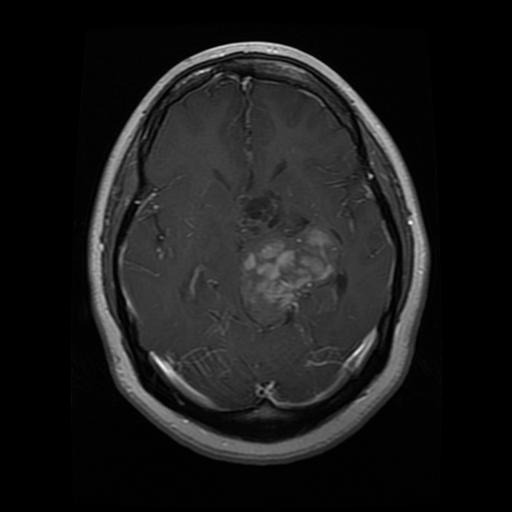

In [7]:
yeses = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yeses[0]))

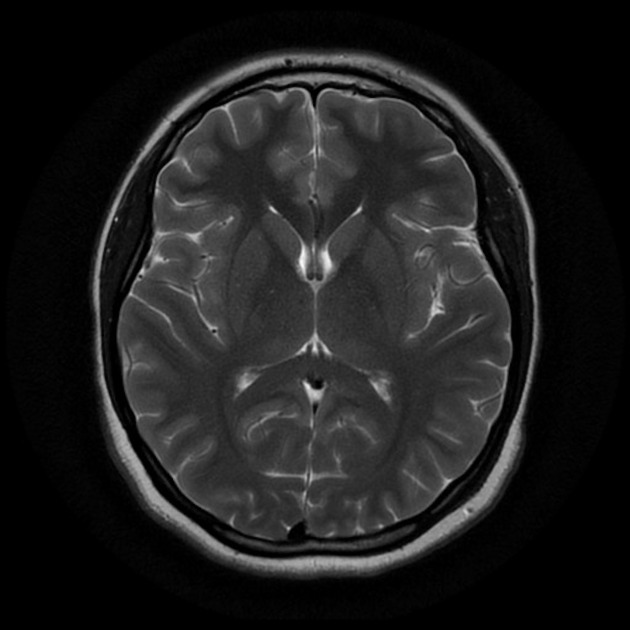

In [8]:
nos = list(data_dir.glob('no/*'))
PIL.Image.open(str(nos[0]))

##  In the following steps we will create and bifurcate the dataset into training and testing sets.

From the project scoping the following are the defined parameters for the images.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

For our validation split we are using 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6123 files belonging to 2 classes.
Using 4899 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6123 files belonging to 2 classes.
Using 1224 files for validation.


The direcetory is divided into yes and no which are defined as `class_names`.

In [12]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## The following method will visualize  some of the data
The following are a sample of 9 brain images with and without tumors.

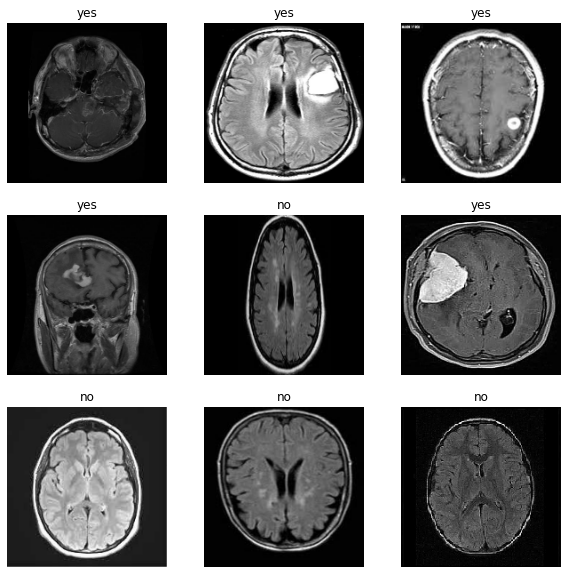

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## To make our input values small we will standardize the data to allow neural network to function smoothly.

In this step we will homogenize the image values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00018590047 0.99965155


# In the following we are create the model to classify tumors

There are three convolution blocks in this tensor flow method which consist of (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. The `tf.keras.layers.Dense` fuctioning layer with 128 units on top of it is operated by a ReLU activation function (`'relu'`).

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## In the first step we will compile the model

We are using the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. For each training epoch we will view training and validation accuracy and pass the `metrics` argument to `Model.compile`.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##  We use 'Model.summary' to see all the layers of the network to give the model summary.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

##  In this step we are now training the model.

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
154/154 [==============================] - 90s 575ms/step - loss: 0.4208 - accuracy: 0.8124 - val_loss: 0.3691 - val_accuracy: 0.8382
Epoch 2/10
154/154 [==============================] - 112s 727ms/step - loss: 0.1930 - accuracy: 0.9302 - val_loss: 0.1672 - val_accuracy: 0.9355
Epoch 3/10
154/154 [==============================] - 105s 683ms/step - loss: 0.1052 - accuracy: 0.9641 - val_loss: 0.0967 - val_accuracy: 0.9698
Epoch 4/10
154/154 [==============================] - 87s 566ms/step - loss: 0.0495 - accuracy: 0.9843 - val_loss: 0.1000 - val_accuracy: 0.9739
Epoch 5/10
154/154 [==============================] - 115s 747ms/step - loss: 0.0347 - accuracy: 0.9896 - val_loss: 0.1057 - val_accuracy: 0.9747
Epoch 6/10
154/154 [==============================] - 136s 883ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.1011 - val_accuracy: 0.9804
Epoch 7/10
154/154 [==============================] - 110s 712ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.1037 - v

## We are visualizing training results by creating plots of accuracy on the training and validation sets.

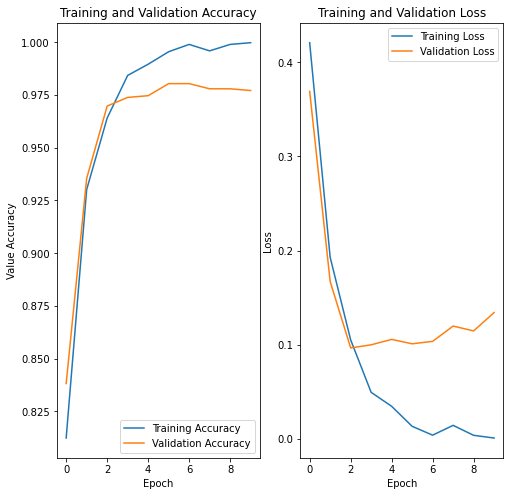

Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Value Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy have small margins, and the model has achieved only around 98% accuracy on the validation set.


## We can now use other images to see whether our model can predict on new data( Testing the model)

This image was not included in the training and validation sets obttained from the Kaggle testing dataset.It is an image of a pituitay tumour and should belong to the yes category.

In [22]:
testing_path = pathlib.Path('TestingImage.jpg')

In [23]:

img = tf.keras.utils.load_img(
    testing_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to yes with a 100.00 percent confidence.


In [ ]:
Our model can accurately identify tumors and is ready for real world testing.

In [ ]:
# imported necessary libraries
import gradio as gr
import tensorflow as tf
import numpy as np
import requests

# loading the model
inception_net = tf.keras.applications.InceptionV3()

# Download human-readable labels.
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")

def classify_image(img):
	""" Returns a dictionary with key as label and values
	as the predicted confidence for that label"""
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    return  "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))

# initializing the input component
image = gr.inputs.Image(shape = (299, 299, 3))
# initializing the output component
label = gr.outputs.Label(num_top_classes = 3)

# launching the interface
gr.Interface(fn = classify_image, inputs = image,
			outputs = label, capture_session = True).launch()


In [28]:
import anvil.server #This server provides a front end dashboard that can be used to upload images 
anvil.server.connect("server_2LKAA43YQP4UDBGPJCQAP7OR-Y7HGABTP3F4FKG7I")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [31]:
import anvil.media

@anvil.server.callable
def classify_image(testing_path):
    with anvil.media.Tempfile(testing_path) as testing_path:
        
        img = tf.keras.utils.load_img(
            testing_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        return  "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))



In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = load_img(filename)
         # Inside the classify_image function

    img = img.resize((128, 128), resample=PIL.Image.BICUBIC)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255
     score = model.predict(arr)
    return ('dog' if score < 0.5 else 'cat', float(score))
def file_loader_1_change(self, file, **event_args):
    """This method is called when a new file is loaded into this FileLoader."""
    result, score = anvil.server.call('classify_image', file)
    
    self.result_lbl.text = "%s (%0.2f)" % (result, score)
    self.image_1.source = file